In [111]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

reading Raster with rasterio

In [82]:
raster_path = "T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [58]:
raster_img.shape

(3, 10980, 10980)

using rasterio reshape to plot an image in matplotlib

In [59]:
raster_img = reshape_as_image(raster_img)

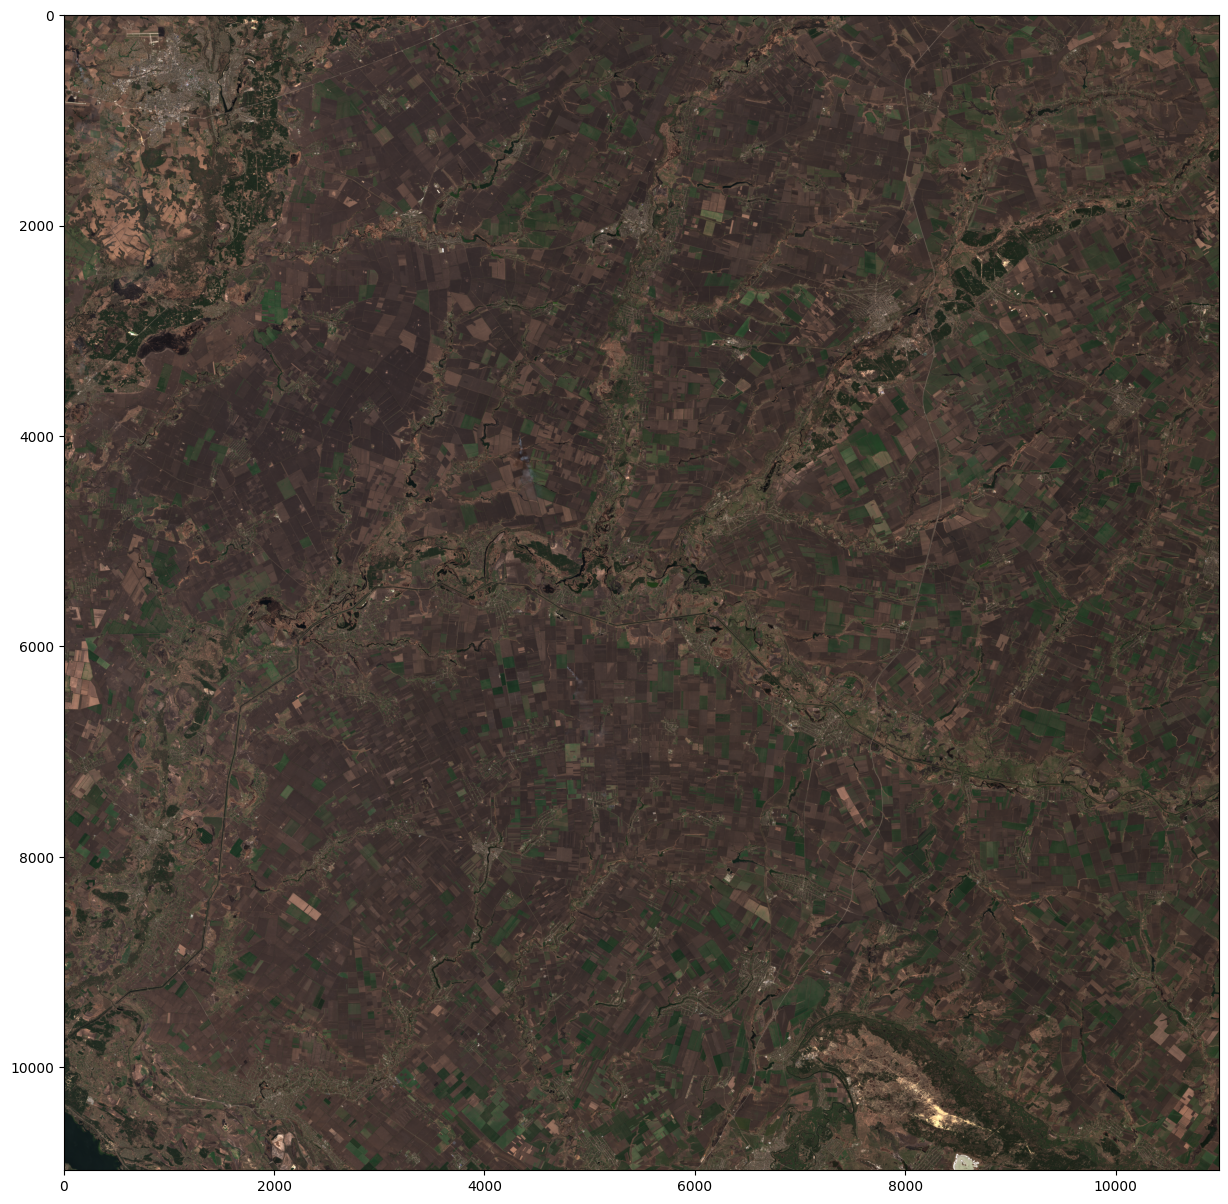

In [60]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

reading train labels with GeoPandas

In [64]:
train_df = gpd.read_file("masks/Masks_T36UXV_20190427.shp")


# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = {'init' :'epsg:4267'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

C:\Users\Настя\PycharmProjects\pythonProject\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


cutting fields from Raster

In [65]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "article"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['Field_Id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
#         print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 935 files


preparing binary mask

C:\Users\Настя\AppData\Local\Temp\ipykernel_5284\988204699.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


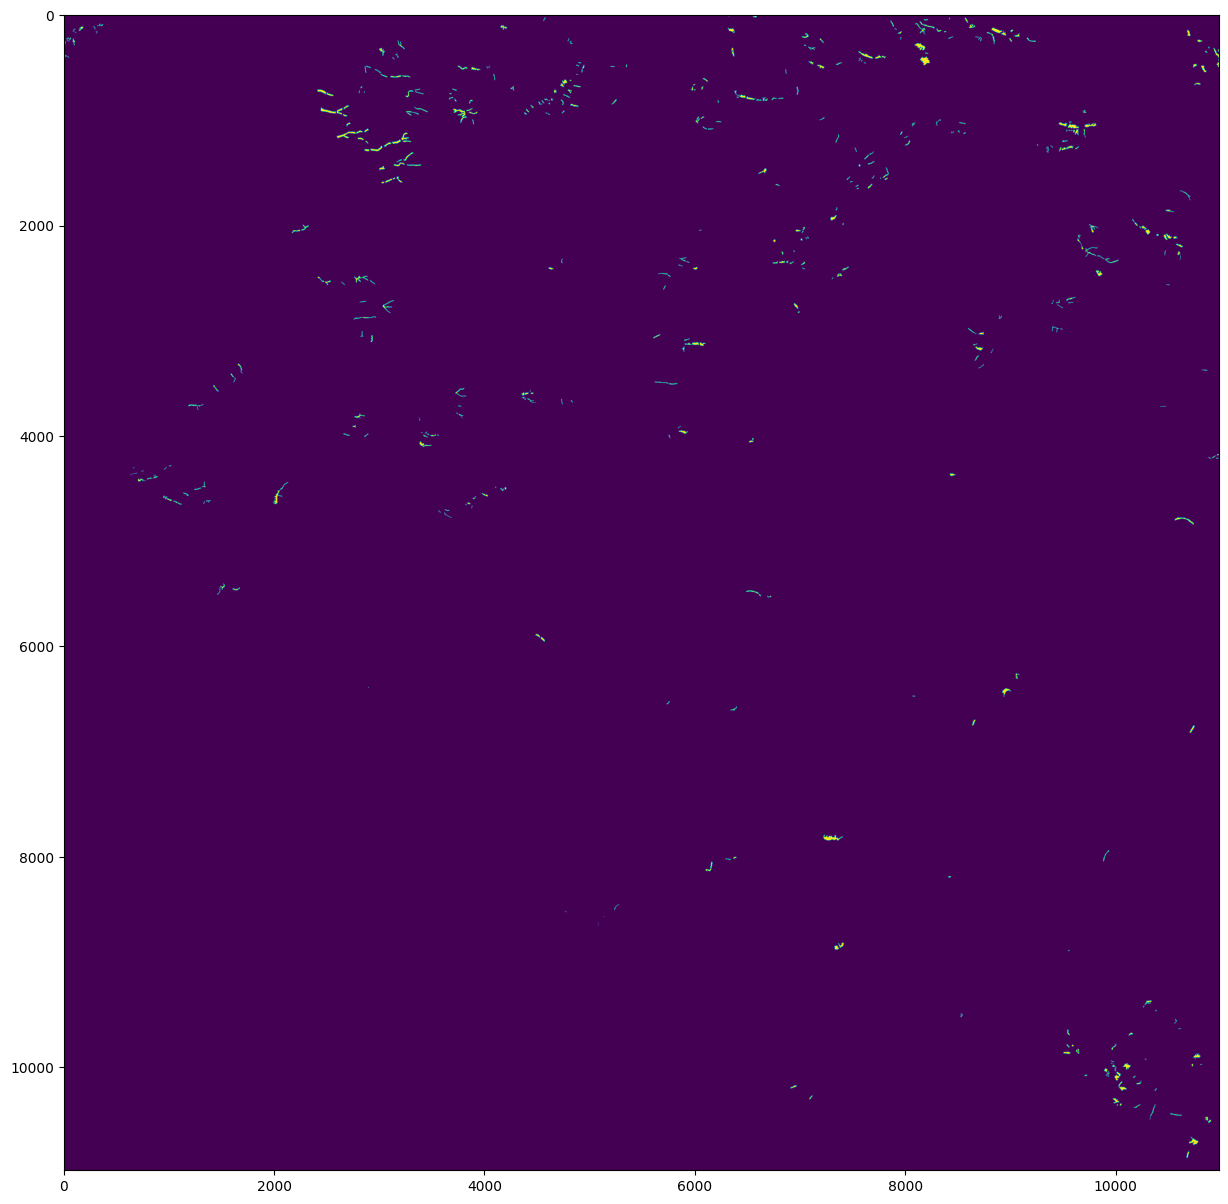

In [66]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

In [72]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("train.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

configuring tiles

In [73]:
tile_size = (256, 256)
batch_size = 16
epochs = 50
learning_rate = 1e-4

In [74]:
tcir_path = raster_path
mask_path = 'train.jp2'
tcir = cv2.imread(tcir_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

split TCI raster and binary mask into tiles

In [78]:
tcir_tiles = []
mask_tiles = []

for i in range(tcir.shape[-1]):
    tcir_channel = tcir[..., i:i+1]
    tcir_channel_tiles = tf.image.extract_patches(
        images=tf.expand_dims(tcir_channel, axis=0),
        sizes=[1, tile_size[0], tile_size[1], 1],
        strides=[1, tile_size[0], tile_size[1], 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    ).numpy().reshape(-1, tile_size[0], tile_size[1], 1)
    tcir_tiles.append(tcir_channel_tiles)

mask_tiles = tf.image.extract_patches(
    images=tf.expand_dims(tf.expand_dims(mask, axis=0), axis=-1),
    sizes=[1, tile_size[0], tile_size[1], 1],
    strides=[1, tile_size[0], tile_size[1], 1],
    rates=[1, 1, 1, 1],
    padding='SAME'
).numpy().reshape(-1, tile_size[0], tile_size[1], 1)

tcir_tiles = np.concatenate(tcir_tiles, axis=-1)

In [79]:
tcir_tiles = tcir_tiles / 255.0
mask_tiles = mask_tiles / 255.0

defining model architecture

In [87]:
inputs = Input(shape=(tile_size[0], tile_size[1], 3))
conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop5)
up6 = concatenate([up6, drop4], axis=3)
conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3], axis=3)
conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2], axis=3)
conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

In [88]:
outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

In [89]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(lr=learning_rate), loss=binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_13[0][0]']              
                                )                                                             